In [13]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
# from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
from utils_train import test_inds, test_days
register_matplotlib_converters()
import numpy as np

np.random.seed(42)

In [14]:
data = Dataset('Wingbeats')
print(data.target_classes)

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']


In [15]:
data.read('Ae. aegypti', loadmat=False)
x1 = data.filenames.sample(14800)
data.read('Ae. albopictus', loadmat=False)
x2 = data.filenames.sample(14800)
data.read('An. arabiensis', loadmat=False)
x3 = data.filenames.sample(14800)
data.read('An. gambiae', loadmat=False)
x4 = data.filenames.sample(14800)
data.read('C. pipiens', loadmat=False)
x5 = data.filenames.sample(14800)
data.read('C. quinquefasciatus', loadmat=False)
x6 = data.filenames.sample(14800)

Data: Ae. aegypti.
Read 85553 filenames in 1.79 seconds.
Data: Ae. albopictus.
Read 20231 filenames in 1.76 seconds.
Data: An. arabiensis.
Read 19297 filenames in 1.76 seconds.
Data: An. gambiae.
Read 49471 filenames in 1.78 seconds.
Data: C. pipiens.
Read 30415 filenames in 1.87 seconds.
Data: C. quinquefasciatus.
Read 74599 filenames in 2.02 seconds.


In [16]:
X = pd.concat([x1, x2, x3, x4, x5, x6], axis=0)
y = X.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [18]:
from sklearn.utils import shuffle
from utils_train import train_test_val_split

X,y = shuffle(X.tolist(),y.tolist(), random_state=0)

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y,test_size=0.13514, val_size=0.2)

In [19]:
keys = pd.Series(le.inverse_transform(y_train)).value_counts().index.tolist()
values = pd.Series(y_train).value_counts().index.tolist()
mapping = dict(zip(keys, values))
print(sorted(mapping.items(), key=lambda x: x[1]))
vcounts = pd.Series(y_train).value_counts()
vcounts.index = mapping.keys()
print(vcounts)

[('Ae. albopictus', 0), ('An. arabiensis', 1), ('Ae. aegypti', 2), ('C. quinquefasciatus', 3), ('C. pipiens', 4), ('An. gambiae', 5)]


An. gambiae            10240
C. quinquefasciatus    10240
Ae. aegypti            10240
An. arabiensis         10240
Ae. albopictus         10240
C. pipiens             10239
dtype: int64

In [20]:
df_train = make_df_parallel(setting='raw', names=X_train+X_val)
# df_val = make_df_parallel(setting='psd_dB', names=X_val)
df_test = make_df_parallel(setting='raw', names=X_test)

In [21]:
y_train = y_train + y_val

## MODELING

## k-Nearest Neighbors

In [1]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()#with_std=True)

# x_train = sc.fit_transform(df_train.values)
# x_test = sc.fit_transform(df_test.values)


In [2]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV, cross_val_score

# grid_params = {
#     'n_neighbors': [11, 13, 15, 17],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# gs = GridSearchCV(KNeighborsClassifier(),
#                  grid_params,
#                  verbose=1,
#                  cv=5,
#                  n_jobs=-1)

In [3]:
# gs_results = gs.fit(x_train, y_train)

## XGBoost grid search

In [23]:
x_train = df_train.values
x_test = df_test.values

In [26]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

parameters = {'max_depth': range (2, 4, 1),
              'n_estimators': range(220, 380, 40),
              'learning_rate': [0.2, 0.3, 0.4],
              'gamma': [0, 0.5, 1, 3]}

estimator = XGBClassifier(param_grid=parameters,
                          random_state=0,
                          seed=42,
                          verbose=True)

gs_xgb = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=True)

gs_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/ho

KeyboardInterrupt: 

In [12]:
print(gs_xgb.best_estimator_)

NameError: name 'gs_xgb' is not defined

Balanced Accuracy Score: 0.5256666666666666


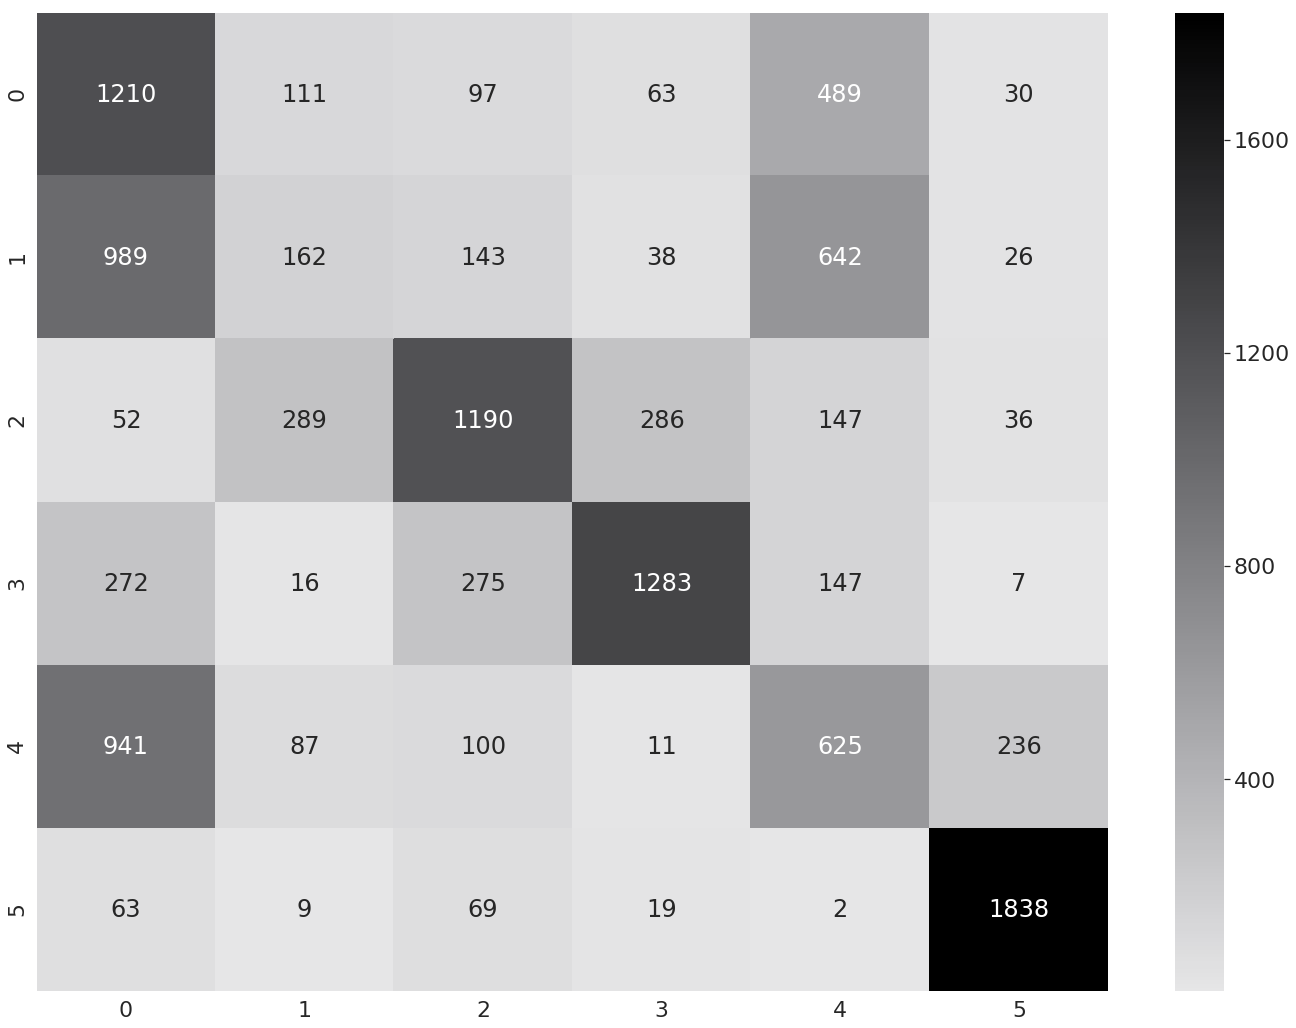

In [24]:
classifier = gs_xgb.best_estimator_

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)

from sklearn.metrics import confusion_matrix,balanced_accuracy_score

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))